# Sequential processing with LSTM RNNs

In this notebook we will be implementing the **LSTM (long short-term memory)** architecture, a type of recurrent neural network. We will then be using this architecture to perform a sequential processing task. This task will be **sequential MNIST (sMNIST)**. sMNIST involves feeding in an MNIST image to a network over time, and then asking the network on the last timestep what label the image had. We will be feeding in the image line by line. 

In [1]:
# First import all the packages we'll need
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import scipy
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Download the MNIST dataset and create the dataloaders for it
# Perform standard data augmentation, but then also re-shape the tensors to get rid of the input channel dimension.

transform = transforms.Compose([ 
    transforms.RandomAffine(degrees=10, translate = (0.05,0.05), scale = (0.95,1.05)),
    transforms.ToTensor(),
    transforms.Lambda( lambda x: x.squeeze())
])

training_data = torchvision.datasets.MNIST(train=True, download = True, root='./data', transform=transform)
testing_data = torchvision.datasets.MNIST(train=False, download = True, root='./data', transform=transform)

train_dataloader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(testing_data, shuffle=False, batch_size=32)

In [3]:
# View the shape of a data point
next(iter(train_dataloader))[0].shape

torch.Size([32, 28, 28])

## Basics of the LSTM architecture
We will be implementing our own version of the LSTM cell. The LSTM cell will take in a $d$-dimensional input and output a $n$-dimensional output. We will introduce the following notation:
1. **The cell input** at time $t$, $x_t \in \mathbb{R}^d$ 
2. **The internal state of the cell** at time $t$, $c_t \in \mathbb{R}^n$
3. **The output of the cell** at time $t$, $v_t \in \mathbb{R}^n$

At each time step, the internal state is updated and used to determine the output of the cell. This is done using three gates:
1. **Forget gate**: the forget gate $f_t$ determines how to downweight the information currently contained in the internal state
2. **Output gate**: the output gate $o_t$ determines how to weight (a transform of) the internal state to generate the output 
3. **Input gate**: the input gate $i_t$ determines how to weight the input to the cell before using it to update the internal state

All the gates are vectors of length $n$ with values between $0$ and $1$. These gates act as *dynamic weights*.

## Gates
To get the value of each gate, we go through the following steps:
1. The gate takes in the input at the current time step $x_t$ and the output of the cell at the previous time step $v_{t-1}$. 
2. These are then transformed by a linear transform, $W x_t + M v_{t-1} + b$ where $W \in \mathbb{R}^{n \times d}$ and $M \in \mathbb{R}^{n \times n}$ are the weight matrices of the gate and $b \in \mathbb{R}^n$ is the bias of the gate
3. These are then passed through a *sigmoid* activation function, $\sigma(x) = 1/(1 + e^{-x})$.

Using sub-scripts to denote which gate we're talking about, we arrive at the following equations for the forget gate $f_t$, output gate $o_t$ and input gate $i_t$ at time $t$, 
$$ f_t = \sigma( W_f x_t + M_f v_{t-1} + b_f ) $$
$$ o_t = \sigma( W_o x_t + M_o v_{t-1} + b_o ) $$
$$ i_t = \sigma( W_i x_t + M_i v_{t-1} + b_i ) $$

## Candidate internal state
We need one final ingredient, the candidate internal state, $\tilde{c}_t \in \mathbb{R}^n$. These are the proposed new values for the cell's internal state. We obtain these values in the same way as we obtain the gate values, by performing a linear combination of the input and the previous output, and then passing through a non-linearity $F$. Usually we take $F = \tanh$. This gives:
$$ \tilde{c}_t = F( W_c x_t + M_c v_{t-1} + b_c ) $$

## Putting it together
We now have the gates $f_t$, $o_t$, and $i_t$. How are these gates used to update the cell's internal state and generate the cell's output? 
### Updating the internal state
To update the internal state, we go through the following steps:
1. Down-weight the previous internal state using the forget gate, $f_t \odot c_{t-1}$
2. Down-weight the candidate internal state via the input gate, $i_t \odot \tilde{c}_t$
3. Add these together, $c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$

### Generating the output
To generate the output at the current time step $v_t$, we go through the following steps:
1. Transform the new internal state using a $\tanh$ non-linearity, $\tanh(c_t)$ 
2. Down-weight using the output gate $v_t = o_t \odot \tanh(c_t)$

In [9]:
# Define the my_LSTM class which inherits from nn.Module. This will be our implemetaion of a single LSTM cell.
class my_LSTM(nn.Module):
    # Define the __init__ method. This will take in the input dimension d and output dimension n
    def __init__(self, d, n):
        # Call the super method and store relevant properties.
        super().__init__()
        self.d = d
        self.n = n

        # Define a ModuleDict object to store our layers
        self.layers = nn.ModuleDict({
            # Linear transform for the forget gate
            "forget": nn.Linear(n+d, n),
            # Linear transform for the input gate
            "input": nn.Linear(n+d, n),
            # Linear transform for the output gate
            "output": nn.Linear(n+d, n),
            # Linear transform for the candidate internal state
            "candidate": nn.Linear(n+d, n)
        })

    # Define the forward method of the LSTM cell. 
    # This will take in:
        # (1) the internal state from the previous time step c
        # (2) the input to the cell at the current time step x
        # (3) the previous output of the cell v
    # The method will output: 
        # (1) the internal state at the current time step
        # (2) the output of the cell at the current time step. 
    def forward(self, c, x, v):
        # Concatenate the previous output of the cell and the input at the current time step 
        vx = torch.cat([v, x], dim=1)

        # Generate the candidate internal state
        c_tilde = F.tanh(self.layers["candidate"](vx))

        # Generate the forget, input, and output gates
        f = F.sigmoid(self.layers["forget"](vx))
        i = F.sigmoid(self.layers["input"](vx))
        o = F.sigmoid(self.layers["output"](vx))

        # Generate the new internal state
        c = f*c + i*c_tilde

        # Generate the output
        v = o*F.tanh(c)

        # Return the internal state and output
        return c, v


## Network architecture
We now have define an LSTM cell. How can we build a network around this to perform a task? We actually don't need to do much to augment the LSTM cell. We will just add a linear readout layer. This layer will project from the LSTM output dimension (of size n) to the 10 logits for each class (there are 10 logits because we are doing MNIST). We will also define a forward method that can take in an image, unroll it into a time-series, and then pass it through one line at a time to the LSTM cell. 

In [10]:
# Define our recurrent neural network class (which inherits from nn.Module)
class my_RNN(nn.Module):
    # Define the __init__ method. This will take in the input dimension of the problem d
    def __init__(self, d, n): 
        # Call the super method and store relevant variables. 
        super().__init__()
        self.d = d
        self.n = n

        # Define a ModuleDict object to store our layers
        self.layers = nn.ModuleDict({
            # The LSTM layer
            "LSTM cell": my_LSTM(d, n),
            # The output layer. This maps from the hidden state of the LSTM to the logits for each class.
            "output": nn.Linear(n, 10)
        })

    # Define the forward method. This will take in a batch of images to be processed and output a the logits for each class and each batch element.  
    def forward(self, X):
        # X is a batch of images. It has shape (batch size, input dimension, sequence length)
        # Extract the batch size and sequence length from the input
        batch_size, _, sequence_length = X.shape

        # Initialize the internal state of the LSTM cell and the output of the cell
        c = torch.zeros(batch_size, self.n)
        v = torch.zeros(batch_size, self.n)
        
        # Iterate through the input time-series, repeatedly passing it through the LSTM cell.
        for t in range(sequence_length):
            # Extract the input at the current time step
            x = X[:,:,t]

            # Pass the input and internal state through the LSTM cell
            c, v = self.layers["LSTM cell"](c, x, v)
        # Pass the final output through the output layer and return the result. 
        # These will be the logits for each class.
        return self.layers["output"](v)


## Training our network
Now that we've designed the network architecture, we will train the network. This involves our standard steps in PyTorch:
1. Define instances of the network, optimiser for that network, and loss function
2. For each epoch, iterate through the dataset and perform the following steps:
    1. Zero out gradients
    2. Perform a forward pass
    3. Compute the loss
    4. Back-propagate 
    5. Take a step using the optimiser
3. Test the performance of the network on the test dataset

In [11]:
# Generate an instance of our LSTM network
my_net = my_RNN(28, 100)

In [12]:
# Define our optimizer
optimizer = optim.Adam(my_net.parameters(), lr=0.001)
# Define our loss function
loss_fn = nn.CrossEntropyLoss()

In [13]:
# Initialise a list to store the training loss
losses = []
# Iterate through epochs
for epoch in range(2):
    # Iterate through the training data loader
    for X, Y in tqdm.tqdm(train_dataloader):    
        # Zero the gradients
        optimizer.zero_grad()
        # Pass the data through the network
        logits = my_net(X)
        # Calculate the loss
        loss = loss_fn(logits, Y)
        # Backpropagate
        loss.backward()
        # Update the weights
        optimizer.step()
        # Append the loss to the list
        losses.append(loss.item())

100%|██████████| 1875/1875 [01:22<00:00, 22.67it/s]


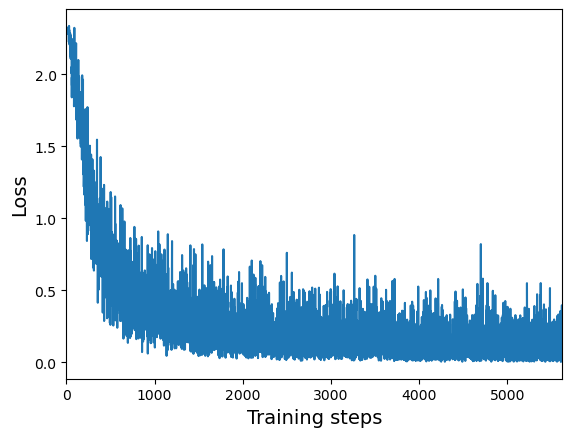

In [18]:
# Plot the training loss
plt.plot(losses)
plt.xlim(0, len(losses))
plt.xlabel("Training steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

In [20]:
# Calculate the accuracy on the test set
correct = 0
total = 0
# Iterate through the test set
for X, Y in test_dataloader:
    # Pass the data through the network
    logits = my_net(X)
    # Get the predicted class
    _, predicted = torch.max(logits.data, 1)
    # Update the counters
    total += Y.size(0)
    correct += (predicted == Y).sum().item()

# Print the accuracy
print("Accuracy: {}%".format(100*correct/total))

Accuracy: 96.73%
